<a href="https://colab.research.google.com/github/ipeirotis/dealing_with_data/blob/master/11-Flask/I-All_Elements_Together.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# All pieces together

This is just a notebook that puts together all the pieces of the code that we have been writing during this tutorial.

In [1]:
!pip install -U PyMySQL sqlalchemy flask pyngrok geopandas pygeos

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 861 kB/s 
     |████████████████████████████████| 101 kB 3.3 MB/s 
     |████████████████████████████████| 745 kB 37.4 MB/s 
     |████████████████████████████████| 1.0 MB 34.5 MB/s 
     |████████████████████████████████| 2.1 MB 24.6 MB/s 
     |████████████████████████████████| 96 kB 2.4 MB/s 
     |████████████████████████████████| 133 kB 2.7 MB/s 
     |████████████████████████████████| 232 kB 20.1 MB/s 
     |████████████████████████████████| 16.7 MB 13.7 MB/s 
     |████████████████████████████████| 6.3 MB 16.2 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19007 sha256=c9b640905e7244fbebb9fb445acb5e6d70eee7b8a6ffac418f0402df1fafb536
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok
  Attempting uninstall: click
    Found 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import threading

from flask import Flask, render_template, jsonify, request
from pyngrok import ngrok

from sqlalchemy import create_engine
import pandas as pd
import base64
from io import BytesIO
import matplotlib.pyplot as plt

# Setup Flask and ngrok

os.environ["FLASK_DEBUG"] = "true"

app = Flask(__name__, 
            template_folder = '/content/drive/MyDrive/templates',
            static_folder  = '/content/drive/MyDrive/static'
            )
port = 5000

# Open a ngrok tunnel to the HTTP server
ngrok_authtoken = '2EYf3qVk9mi739HjPwSNZXWAtfy_4jF9NAhGqVVVJmm4YehPW'
ngrok.set_auth_token(ngrok_authtoken)
public_url = ngrok.connect(port).public_url
print(f" * ngrok tunnel '{public_url}' -> 'http://127.0.0.1:{port}'")

# Update any base URLs to use the public ngrok URL
app.config["BASE_URL"] = public_url

# Setup a connection to the database
conn_string = 'mysql+pymysql://{user}:{password}@{host}/{db}?charset={encoding}'.format(
    host = 'db.ipeirotis.org', 
    user = 'student',
    db = 'citibike_fall2017',
    password = 'dwdstudent2015',
    encoding = 'utf8mb4')
engine = create_engine(conn_string)

 * ngrok tunnel 'http://bd58-35-243-186-0.ngrok.io' -> 'http://127.0.0.1:5000'


In [2]:
@app.route('/')
def home():
    return render_template('search_stations.html')

@app.route('/list_stations',  methods=['GET'])
def list_stations():
    return render_template("list_stations.html")    

In [3]:
@app.route('/citibike_api')
def citibike_stations():

  search_query = request.args.get('name')

  sql = "SELECT DISTINCT id, name, capacity, lat, lon  FROM status_fall2017" 
  if search_query:
    sql += " WHERE name LIKE %(station_name_query)s"

  print(sql)
  print(search_query)

  with engine.connect() as con:
    if search_query: params = {"station_name_query": '%'+search_query+'%' }
    else: params = {}
    
    stations = pd.read_sql(sql, con=con, params=params)

  list_of_stations = stations.to_dict(orient='records')

  api_results = {"stations": list_of_stations}

  # We JSON-ify our dictionary and return it as the API response
  return jsonify(api_results)

In [4]:
@app.route('/station_map',  methods=['GET'])
def station_map():

    # Connect to the database, execute the query, and get back the results
    sql = "SELECT DISTINCT id, name, capacity, lat, lon  FROM status_fall2017" 
    with engine.connect() as connection:  
        stations = pd.read_sql(sql, con=connection)

    fig, ax = plt.subplots()
    ax = stations.plot(kind='scatter', x='lon', y='lat', figsize=(6,6), ax=ax)

    buf = BytesIO()
    fig.savefig(buf, format="png")
    # Embed the result in the html output.
    data = base64.b64encode(buf.getbuffer()).decode("ascii")

    # Create the response. We will put the retrieved data as a list of
    # dictionaries, under the key "stations".
    results = {"image": data}

    # We JSON-ify our dictionary and return it as the API response
    return jsonify(results)

 * ngrok tunnel 'http://bd58-35-243-186-0.ngrok.io' -> 'http://127.0.0.1:5000'
 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [03/Nov/2022 19:45:03] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [03/Nov/2022 19:45:03] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [03/Nov/2022 19:45:06] "GET /list_stations?name=bleek HTTP/1.1" 200 -


SELECT DISTINCT id, name, capacity, lat, lon  FROM status_fall2017 WHERE name LIKE %(station_name_query)s
bleek


INFO:werkzeug:127.0.0.1 - - [03/Nov/2022 19:45:07] "GET /citibike_api?name=bleek HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [03/Nov/2022 19:45:12] "GET /list_stations?name=blee HTTP/1.1" 200 -


SELECT DISTINCT id, name, capacity, lat, lon  FROM status_fall2017 WHERE name LIKE %(station_name_query)s
blee


INFO:werkzeug:127.0.0.1 - - [03/Nov/2022 19:45:12] "GET /citibike_api?name=blee HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [03/Nov/2022 19:45:13] "GET /station_map HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [03/Nov/2022 19:54:14] "GET /list_stations?name=re HTTP/1.1" 200 -


SELECT DISTINCT id, name, capacity, lat, lon  FROM status_fall2017 WHERE name LIKE %(station_name_query)s
re


INFO:werkzeug:127.0.0.1 - - [03/Nov/2022 19:54:15] "GET /citibike_api?name=re HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [03/Nov/2022 19:54:16] "GET /station_map HTTP/1.1" 200 -


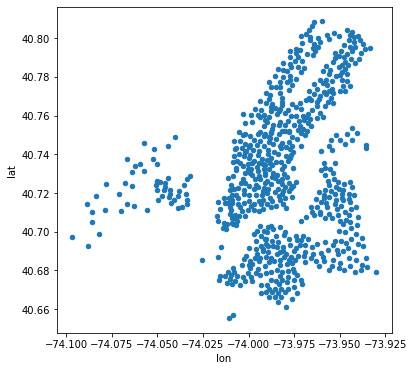

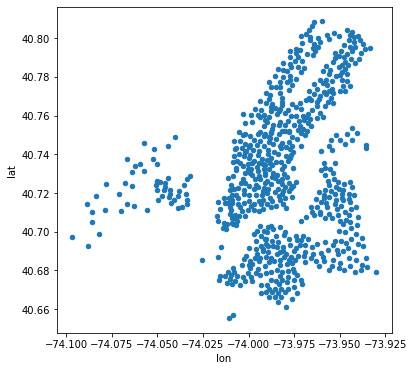

In [5]:
# You can visit then https:///station_status?station_id=72
# and see the results

print(f" * ngrok tunnel '{public_url}' -> 'http://127.0.0.1:{port}'")
app.run(use_reloader=False, port=port)

**`search_stations.html`**

```html
<!DOCTYPE html>
<html>

<head>
	<link href="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/css/bootstrap.min.css" rel="stylesheet" integrity="sha384-Zenh87qX5JnK2Jl0vWa8Ck2rdkQ2Bzep5IDxbcnCeuOxjzrPF/et3URy9Bv1WTRi" crossorigin="anonymous">

	<title>Search Citibike Stations</title>

</head>

<body>
	<div class="container">
		<div class="panel panel-info">
			<div class="panel-heading" align="center">
				<h1>
					<form action="/list_stations">
						Station Name<br>
						<input type="text" name="name"><br>
						<input class="btn btn-primary" type="submit" value="Submit">
          				</form>
				</h1>
			</div>
		</div>
	</div>
</body>
```

`citibike.html`

```html
<!DOCTYPE html>
<html>
<head>
    <link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.1.3/css/bootstrap.min.css" integrity="sha384-MCw98/SFnGE8fJT3GXwEOngsV7Zt27NXFoaoApmYm81iuXoPkFOJwJ8ERdknLPMO" crossorigin="anonymous">
</head>
<body>  
  <div class="container">
    <div class="panel panel-info">
      <div class="panel-heading">
          <h1 class="panel-title">Citibike Stations</h1>
      </div>
      <table  class="table table-striped table-bordered table-hover">
      <thead>
          <tr> 
            <th>Station ID</th>
            <th>Address</th>
            <th>Capacity</th>
            <th>Lon / Lat</th>
          </tr>
      </thead>
      <tbody>
          {% for station in stations %}    <!-- Fill table rows for each station --> 
              <tr>
                  <td><a href="/station_status?station_id={{ station.station_id }}">{{ station.station_id }}</a></td>
                  <td><a href="/station_status?station_id={{ station.station_id }}">{{ station.name }}</a></td>
                  <td>{{ station.capacity }}</td>
                  <td>{{ station.lon }}, {{ station.lat }}</td>
              </tr>
          {% endfor %}
        </tbody>
      </table>
    </div>
  </div>
</body>
</html>
```